In [4]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [5]:
df = pd.read_csv('ex1data1.txt', names=['population', 'profit'])


In [6]:
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


# 原始数据


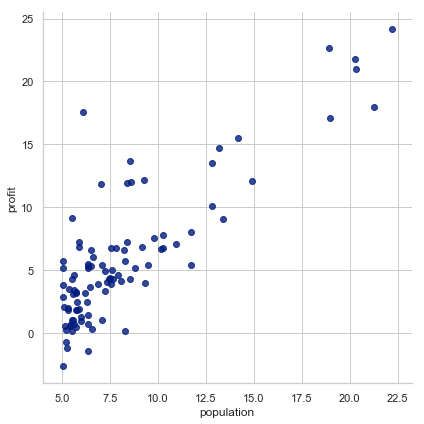

In [10]:
sns.lmplot('population', 'profit', df, height=6, fit_reg=False)
plt.show()


# 处理数据


In [17]:
def get_x(df):  # 读取特征
    ones = pd.DataFrame({'ones':np.ones(len(df))}) # m行1列
    data = pd.concat([ones,df],axis=1) # 合并数据，根据列合并
    return data.iloc[:,:-1].as_matrix()# 返回ndarray

def get_y(df):  # 读取标签
    return np.array(df.iloc[:,-1])  ## df的最后一列


def normalize_feature(df):  # 特征缩放
    return df.apply(lambda column: (column - column.mean()) / column.std())
    
    

In [18]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):# 这个函数是旧金山的一个大神Lucas Shen写的
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row

In [19]:
data = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#读取数据，并赋予列名

data.head()#看下数据前5行


,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [20]:
X = get_x(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))


(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


/Users/liuchuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [21]:
theta = np.zeros(X.shape[1])#X.shape[1]=2,代表特征数n

In [22]:
def lr_cost(theta, X, y):
#     """
#     X: R(m*n), m 样本数, n 特征数
#     y: R(m)
#     theta : R(n), 线性回归的参数
#     """
    m = X.shape[0]#m为样本数

    inner = X @ theta - y  # R(m*1)，X @ theta等价于X.dot(theta)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [23]:
lr_cost(theta, X, y)#返回theta的值

32.072733877455676

# 批量梯度下降


In [24]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta等价于X.dot(theta)

    return inner / m

def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#   拟合线性回归，返回参数和代价
#     epoch: 批处理的轮数
#     """
    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy()  # 拷贝一份，不和原来的theta混淆

    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))

    return _theta, cost_data

In [25]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

In [26]:
final_theta


array([-2.28286727,  1.03099898])

# 计算最终的代价

In [27]:
lr_cost(final_theta, X, y)

4.713809531116866

# 代价数据可视化


/Users/liuchuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/liuchuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


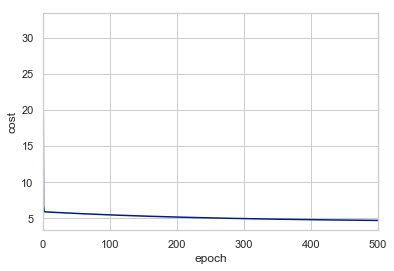

In [31]:
ax = sns.tsplot(cost_data, time=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()

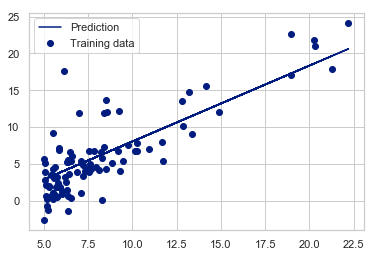

In [32]:
b = final_theta[0] # intercept，Y轴上的截距
m = final_theta[1] # slope，斜率

plt.scatter(data.population, data.profit, label="Training data")
plt.plot(data.population, data.population*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()